<a href="https://colab.research.google.com/github/Alighiamy/Beam-analysis/blob/main/Timoshenko_Beam_Theory_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_in this version we can define both uniform distributed load and concentraited load:_

In [ ]:
%reset-f
import numpy as np
import sympy as sym
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Inputs:
# ______________________________________________________________________________
# Material Properties:
Emudul = 2e5
ν = 0.3
Gmudul = Emudul/(2*(1 + ν))
ρ = 7850 # Density
# ..............................................................................
# Geometic Properties:
by = 0.4 # wigth of the Beam in y direction (mm)
hz = 0.4 # Hight of Beam in z direction (mm)
LB = 100 # Length of the Beam in x direction (mm) 

Asurf= by*hz # (mm^2)
Inersia = by*hz**3/12 # (mm^4)
# ..............................................................................
ElemN = 2 # Number of Beam Elements

Le = LB/ElemN # Length of Each Element
# ..............................................................................
# Load: Kind of Load Distribution: [Con: Concentrated Load, Uni: Uniform distribution]
q = -1 # Load Amplitude (N)
Load_dist = 'Uni' # [Con : Uni]
LoadDistance = 1*LB/2
# ------------------------------------------------------------------------------
# Boundary Condition: [c: Clamped, s: Simply, f: Free]
BCL = 's' # [s : c : f] Left
BCR = 's' # [s : c : f] Right

In [ ]:
# Timoshenko Shear correction Fator and DOFs:
# ______________________________________________________________________________
KKK = 5/6 # [0.66, 2/3, 5/6, 0.86]

#-------------------------------------------------------------------------------
# Degree of Freedom
DPN = 4 # Degree of Freedom per Node (u, v=dw/dx , w)
NPE = 2 # Node per Elements

DPE = DPN*NPE # Degree of Freedom per element
NodeN = ElemN+1 # Number of All Nodes
DOFs = NodeN*DPN

_Material Properties:_

 $\begin{pmatrix}
 F_{x}\\
 M_{y}
\end{pmatrix}=
  \begin{pmatrix}
  EA & 0 \\
             0  & EI
\end{pmatrix}. 
  \begin{pmatrix}
  \epsilon^{0}_{xx}\\
  \epsilon^{1}_{xx}
\end{pmatrix}$

$Qs =GA= K \times A_{s}$

In [ ]:
# Sttifnees Material property Matirx
#===============================================================================
φ=np.zeros((2,2),dtype=float)
#...............................................................................
# Isotropic:

φ[0][0] = Emudul*Asurf # (N)
φ[1][1] = Emudul*Inersia # (N.mm)

As = np.array(Gmudul*Asurf)

#...............................................................................
φs = KKK*As
print(φ)
print(φs)

[[32000.             0.        ]
 [    0.           426.66666667]]
10256.41025641026


In [ ]:
# Shape Functions and their differntation
x = sym.Symbol('x')
N1 = 1 - x/Le
N2 = x/Le
dxN1 = sym.diff(N1, x, 1)
dxN2 = sym.diff(N2, x, 1)

H1 = (1/Le**3) * (Le**3 - 3*Le*x**2 + 2*x**3)
dx1H1 = sym.diff(H1, x, 1)
dx2H1 = sym.diff(H1, x, 2)

H2 = (1/Le**2) * (Le**2*x - 2*Le*x**2 + x**3)
dx1H2 = sym.diff(H2, x, 1)
dx2H2 = sym.diff(H2, x, 2)

H3 = (1/Le**3) * (3*Le*x**2 - 2*x**3)
dx1H3 = sym.diff(H3, x, 1)
dx2H3 = sym.diff(H3, x, 2)

H4 = (1/Le**2) * (x**3 - Le*x**2)
dx1H4 = sym.diff(H4, x, 1)
dx2H4 = sym.diff(H4, x, 2)

###${ϵ_{b}}=B_{b}.𝚫$__:__$
\begin{pmatrix}
\epsilon^{0}_{xx}\\
\epsilon^{1}_{xx}
\end{pmatrix}=
  \begin{pmatrix}
  \frac{du}{dx}\\
  \frac{d ϕ}{dx}
  \end{pmatrix}$
$\begin{align}
K_{b}=\int_{0}^{L_{e}} B_{b}^{T}.Q_{b}.B_{b}\mathrm{d}x \
\end{align}$
_______________________________________________________
###${γ_{s}}=B_{s}.𝚫$

$\begin{align}
K_{s}=\int_{0}^{L_{e}} B_{s}^{T}.KA_{s}.B_{s}\mathrm{d}x \
\end{align}$
_______________________________________________________
 ___Sttifness Matrix of Element:___
$K_{e}=K_{b} + K_{s}$

In [ ]:
# Bending:......................................................................
#                   u1       w1     θ1       ϕ1     u2     w2      θ2     ϕ2
Bb = sym.Matrix([[dxN1,      0,      0,       0,  dxN2,     0,     0,      0],
                 [   0,      0,      0,    dxN1,     0,     0,     0,   dxN2]])
Bb_T = Bb. transpose()
KbE = sym.integrate(Bb_T @ φ @ Bb, (x, 0, Le))
# Shear:........................................................................
#                 u1     w1     θ1    ϕ1     u2       w2     θ2     ϕ2
Bs = sym.Matrix([[0,  dx1H1, dx1H2,   N1,     0,   dx1H3, dx1H4,    N2]])
Bs_T = Bs. transpose()
KsE = sym.integrate((Bs_T @ Bs)*φs, (x, 0, Le))

# KE = KbE + KsE
# KE

In [ ]:
# iterate through rows
KE = sym.Matrix(np.zeros((DPE,DPE),dtype=float))
for i in range(DPE):
   # iterate through columns
   for j in range(DPE):
       KE[i,j] = KbE[i,j] + KsE[i,j]
KE = sym.Matrix(KE)

In [ ]:
KE

Matrix([
[ 640.0,                 0,                 0,                 0, -640.0,                 0,                 0,                 0],
[     0,  246.153846153845,  1025.64102564102, -5128.20512820513,      0, -246.153846153845,  1025.64102564102, -5128.20512820513],
[     0,  1025.64102564102,  68376.0683760676,  42735.0427350425,      0, -1025.64102564103, -17094.0170940175, -42735.0427350427],
[     0, -5128.20512820513,  42735.0427350425,  170948.704273504,      0,  5128.20512820513, -42735.0427350429,  85461.5521367522],
[-640.0,                 0,                 0,                 0,  640.0,                 0,                 0,                 0],
[     0, -246.153846153845, -1025.64102564103,  5128.20512820513,      0,  246.153846153845, -1025.64102564102,  5128.20512820513],
[     0,  1025.64102564102, -17094.0170940175, -42735.0427350429,      0, -1025.64102564102,  68376.0683760685,  42735.0427350427],
[     0, -5128.20512820513, -42735.0427350427,  85461.5521367522,  

__Force Vector of each Element:__
_This is defined for uniform load ditribution_

$\begin{align}
F_{e}=\int_{0}^{L_{e}} N_{e}^{T}q(x)\mathrm{d}x \
\end{align}$

In [ ]:
#                  u1 w1  θ1   ϕ1  u2 w2  θ2  ϕ2
Ne = sym.Matrix([[ 0, H1, H2,  0,  0, H3, H4, 0]])
Ne_T = Ne. transpose()
if Load_dist == 'Uni':
  FE = sym.integrate(Ne_T * q, (x, 0, Le))
elif Load_dist == 'Con':
  Force_E = sym.zeros(DPE,ElemN)
  FE = Ne_T * q
  FE = FE.subs(x,Le)
  for i in range(ElemN):
    if (0+i*Le) <= LoadDistance < (Le+i*Le):
      ConLoadElem = ElemN
      Force_E[:,i] = FE
      FE = Force_E
# FE

In [ ]:
DCON = np.zeros([ElemN,DPE],dtype=int)
DOF_list = list(range(1,DOFs+1))

for j in range(ElemN):
    for i in range(DPE):
        DCON[j][i] = DOF_list [i+DPN*j]

# Using pandas to create a table of DCON
dCon = pd.DataFrame(
    DCON,
    index=list(range(1,ElemN+1)),
    columns=['u1', 'w1', 'θ1','ϕ1','u2','w2','θ2','ϕ2'])
dCon.head()

,u1,w1,θ1,ϕ1,u2,w2,θ2,ϕ2
1,1,2,3,4,5,6,7,8
2,5,6,7,8,9,10,11,12


In [ ]:
# Boundary Condition:
# Left BC:
dof_left = []
if BCL == 's':
  dof_left = DCON[0][[0,1]]-1
elif BCL == 'c':
  dof_left = DCON[0][[0,1,2,3]]-1
elif BCL == 'f':
  dof_left = np.array([])
#-------------------------------------------------------------------------------
# Right BC:
dof_right = []

if BCR == 's':
  dof_right = DCON[-1][[-3,-4]]-1
elif BCR == 'c':
  dof_right = DCON[-1][[-1,-2,-3,-4]]-1
elif BCR == 'f':
  dof_right = np.array([])
#-------------------------------------------------------------------------------
bc_sort = []
bc_sort = np.concatenate((dof_right, dof_left))
bc_sort = np.sort(bc_sort)[::-1]
# bc_sort = sym.Matrix(bc_sort)

In [ ]:
# Calculation Total Sttifness Matirix
KT = sym.Matrix(np.zeros([DOFs,DOFs],dtype=float))
for k in range(ElemN):
    for i in range(DPE):
        for j in range(DPE):
            KT[DCON[k][i]-1,DCON[k][j]-1] += KE[i,j]
#-------------------------------------------------------------------------------
# Column Deleting
KT = np.delete(KT, bc_sort, axis=1)
# Row Deleting
KT = np.delete(KT, bc_sort, axis=0)
KT = sym.Matrix(KT)
# KT

In [ ]:
KT

Matrix([
[ 68376.0683760676,  42735.0427350425,      0,    -1025.64102564103,    -17094.0170940175, -42735.0427350427,               0.0,               0.0],
[ 42735.0427350425,  170948.704273504,      0,     5128.20512820513,    -42735.0427350429,  85461.5521367522,               0.0,               0.0],
[                0,                 0, 1280.0,                    0,                    0,                 0,                 0,                 0],
[-1025.64102564103,  5128.20512820513,      0,     492.307692307691, 3.63797880709171e-12,                 0,  1025.64102564102, -5128.20512820513],
[-17094.0170940175, -42735.0427350429,      0, 3.63797880709171e-12,     136752.136752136,  85470.0854700853, -17094.0170940175, -42735.0427350427],
[-42735.0427350427,  85461.5521367522,      0,                    0,     85470.0854700853,  341897.408547009, -42735.0427350429,  85461.5521367522],
[              0.0,               0.0,      0,     1025.64102564102,    -17094.0170940175, -42735

In [ ]:
# Calculation Total Force Vector
if Load_dist == 'Uni':
  FT = sym.Matrix(np.zeros([DOFs,1],dtype=float))
  for k in range(ElemN):
    for i in range(DPE):
        FT[DCON[k][i]-1] += FE[i]
elif Load_dist == 'Con':
  FT = sym.Matrix(np.zeros([DOFs,1],dtype=float))
  for k in range(ElemN):
    for i in range(DPE):
      FT[DCON[k][i]-1] += FE[i,k]

FT = np.delete(FT, bc_sort)
FT = sym.Matrix(FT)
# FT

###$F = K. 𝚫=>𝚫 = K^{-1}.F$


In [ ]:
# Nodal Displacement:
NodalDip = KT.inv()@FT
# NodalDip

In [ ]:
if BCL == 's':
  NodalDip1 = np.delete(NodalDip, [0,1,-1,-2])
  Wmax_Nodes = [0]
  for i in range(NodeN-2):
      Wmax_Nodes.append(NodalDip1[1+4*i])
  Wmax_Nodes.append(0)
elif BCL == 'c':
  Wmax_Nodes = [0]
  for i in range(NodeN-2):
      Wmax_Nodes.append(NodalDip[1+4*i])
  Wmax_Nodes.append(0)

In [ ]:
np.max(np.abs(Wmax_Nodes))

2441.52812518456

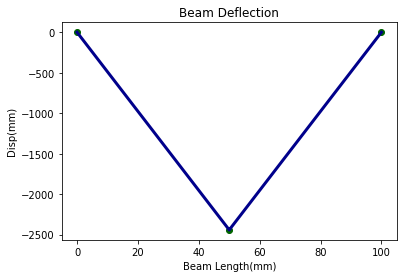

In [ ]:
Y = Wmax_Nodes
X =list(range(0,LB+int(Le),int(Le)))
plt.scatter(X, Y, color='darkgreen')
plt.plot(X, Y, color='darkblue', linewidth=3)
plt.title('Beam Deflection')
plt.ylabel('Disp(mm)')
plt.xlabel('Beam Length(mm)')
plt.show()